# Speech-vs-Music Classifier

#### We want to classify when there is music or speech in audio. 

* Why? Maybe we want to mute the speech and only hear the music or perhaps the opposite
- We build an elementary classifier based on a simple Gaussian model

### Background Literature

This task requires us to use some specific domain knowledge. Below is a list of reference links:

1. https://en.wikipedia.org/wiki/Short-time_Fourier_transform

### Part 0 - Importing packages

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read as wavread
from scipy import signal
import random

### Part 1 - Importing Data
- Sample clips of music and speech

In [15]:
num = 30 #number of files to import
L = 1024 #length of the STFT
hop = int(1024*0.75) #hop size

fs, em = wavread('SpeechMusic/music/1.wav')
f,t,z_m = signal.stft(em,fs,nperseg=L,noverlap=hop)
music_spec_all = 20*np.log10(np.absolute(z_m))

fs, es = wavread('SpeechMusic/speech/1.wav')
f,t,z_s = signal.stft(es, fs,nperseg=L,noverlap=hop)
speech_spec_all = 20*np.log10(np.absolute(z_s))

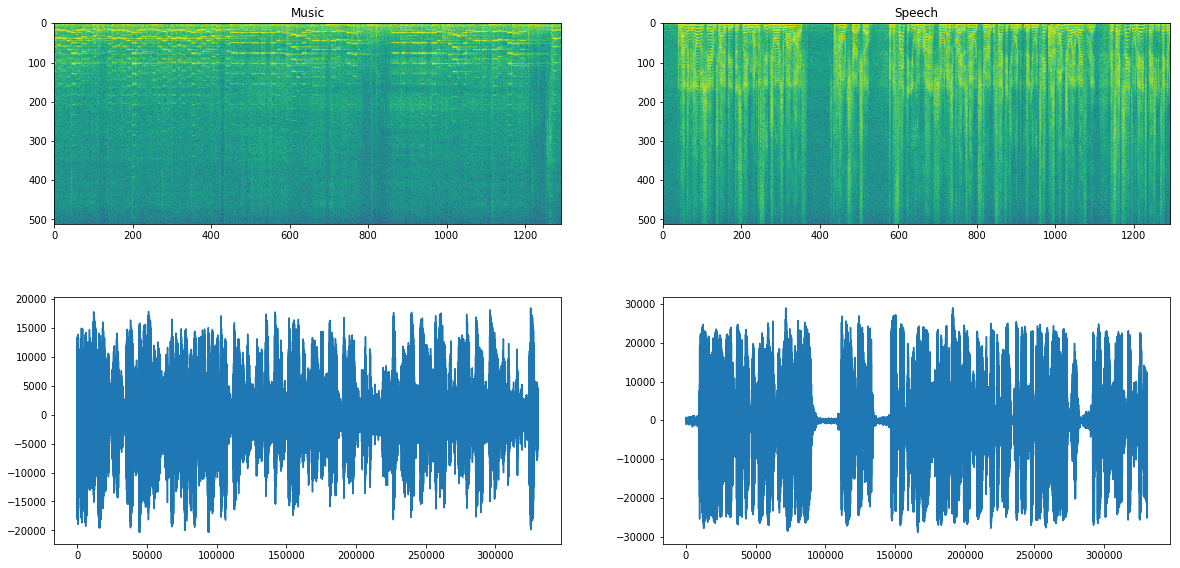

In [16]:
#Plot
plt.figure(figsize=(20,10))

plt.subplot(221)
plt.imshow(music_spec_all)
plt.title('Music')

plt.subplot(223)
plt.plot(em)

plt.subplot(222)
plt.imshow(speech_spec_all)
plt.title('Speech')

plt.subplot(224)
plt.plot(es)

In [17]:
music_data  = np.empty((em.shape[0],num), dtype='float')
speech_data = np.empty((es.shape[0],num), dtype='float') 

for i in range(1,num):
    
    mt = 'SpeechMusic/music/'+str(i+1)+'.wav'
    st = 'SpeechMusic/speech/'+str(i+1)+'.wav'
    
    fsm,music_data[:,i]  = wavread(mt)
    fsm,speech_data[:,i] = wavread(st)
    
    f,t,hm = signal.stft(music_data[:,i],  fsm, nperseg=L,noverlap=hop)
    f,t,hs = signal.stft(speech_data[:,i], fsm, nperseg=L,noverlap=hop)
    
    music_spec_all  = np.concatenate((music_spec_all, 20*np.log10(np.absolute(hm))), axis=1)
    speech_spec_all = np.concatenate((speech_spec_all,20*np.log10(np.absolute(hs))), axis=1)
    

### Part 2 - Training data
- Train 

In [18]:
#10% of data will be used for training each class (music and speech)
numtraining = int((music_spec_all.shape[1])/10)

#draw random samples for training
idm = np.random.randint(music_spec_all.shape[1],size=(1,numtraining)).squeeze()
ids = np.random.randint(music_spec_all.shape[1],size=(1,numtraining)).squeeze()

music_train  = np.empty((music_spec_all.shape[0], numtraining),dtype='float')
speech_train = np.empty((speech_spec_all.shape[0],numtraining),dtype='float')

for j in range(0,numtraining):
    music_train[:,j]  = music_spec_all[:,idm[j]]
    speech_train[:,j] = speech_spec_all[:,idm[j]]
    

#zero center the data
fy = np.concatenate((music_train,speech_train), axis=1)
trainmean = fy.mean(axis=1)

fy = (fy.transpose() - trainmean.reshape(1,-1)).transpose()

music_train  = (music_train.transpose() - trainmean.reshape(1,-1)).transpose()
speech_train = (speech_train.transpose() - trainmean.reshape(1,-1)).transpose()

### Part 3 - Testing Data

In [19]:
num_test_samples = 40 #num of 1 sec samples

test_music_data  = np.empty((num_test_samples,fs), dtype='float')
test_speech_data = np.empty((num_test_samples,fs), dtype='float') 

for k in range(0, num_test_samples):
    
    p1 = random.randint(3, music_data.shape[0]-fs-5)
    p2 = random.randint(3, music_data.shape[0]-fs-5)
    
    l1 = random.randint(1,num-1)
    l2 = random.randint(1,num-1)
    
    #extract 1 sec sample 
    test_music_data[k,:]  = music_data[p1:p1+fs,l1]
    test_speech_data[k,:] = speech_data[p2:p2+fs,l2]

In [20]:
#1st sample of 1 sec
f,t,hm = signal.stft(test_music_data[0,:], fsm, nperseg=L, noverlap=hop)
f,t,hs = signal.stft(test_speech_data[0,:],fsm, nperseg=L, noverlap=hop)

#1st sample of 1 sec has 88 spec vectors
music_validate_set  = np.empty((hm.shape[0], hm.shape[1], test_music_data.shape[0]),dtype='float')
speech_validate_set = np.empty((hs.shape[0], hs.shape[1], test_speech_data.shape[0]),dtype='float')

#stack __?__ such spectograms together
for k in range(0, num_test_samples):
    f,t,hm = signal.stft(test_music_data[k,:], fsm, nperseg=L, noverlap=hop)
    f,t,hs = signal.stft(test_speech_data[k,:],fsm, nperseg=L, noverlap=hop)
    
    music_validate_set[:,:,k]  = (20*np.log10(np.absolute(hm)).transpose() - trainmean.reshape(1,-1)).transpose()
    speech_validate_set[:,:,k] = (20*np.log10(np.absolute(hs)).transpose() - trainmean.reshape(1,-1)).transpose()

### Part 4 - Define Objective

- We see that each 1 sec sample produces 88 spectogram vectors of dimension 513. Define accuracy of classification of each sample is:

$$ accuracy = \frac{correct classification}{88} * 100% $$

### Part 5 - Do PCA and Test

- We are currently dealing with 513 dimensional data but perhaps we can reduce it while preserving the essential information. This helps us speed up computation (of course by sacrificing a little bit of accuracy).

In [21]:
def PCA(dim, data):
    cov_data           = np.cov(data)
    lamda_cov, eig_cov = np.linalg.eig(cov_data)
    a                  = np.linalg.inv(np.diag(np.sqrt(lamda_cov[0:dim].real)))
    W                  = np.dot(a,eig_cov[:,0:dim].T).real
    return W

In [22]:
redu_dim = 20
acc = np.zeros((redu_dim,num_test_samples))

for u in range(2, redu_dim):
    dim = u
    
    W_all    = PCA(dim, fy)
    Z_music  = np.dot(W_all, music_train)
    Z_speech = np.dot(W_all, speech_train)
    
    m_music  = np.mean(Z_music, axis=1)
    m_speech = np.mean(Z_speech, axis=1)
    
    c_music  = np.cov(Z_music)
    c_speech = np.cov(Z_speech) 
    
    g = np.empty((2,88, num_test_samples), dtype='float')
    
    for i in range(0, num_test_samples):
        Z_sample = np.dot(W_all,music_validate_set[:,:,i])
        a = Z_sample.T - m_music
        b = Z_sample.T - m_speech
        
        g[0,:,i] = -0.5*np.sum(np.dot(a, np.linalg.inv(c_music))*a, axis=1) - 2*0.5*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(c_music))
        g[1,:,i] = -0.5*np.sum(np.dot(b, np.linalg.inv(c_speech))*b, axis=1) -2*0.5*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(c_speech))

    p = np.empty((num_test_samples,88))
    for j in range(0, num_test_samples):
        for i in range(0,88):
            p[j,i] = np.argmax(g[:,i,j])
    
    for j in range(0, num_test_samples):
        acc[u,j] = (1 - float(np.sum(p[j,:]))/88.0)*100

### Part 6 - Results

#### Music samples
- Let's see how accurately we can classify 5 music sample

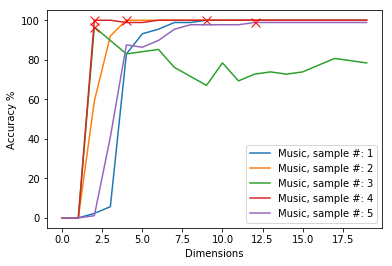

In [56]:
fig = plt.figure(num=None)
ax = fig.add_subplot(111)

for i in range(0,5):
    x = np.arange(0,acc.shape[0])
    y = acc[:,i]
    line, = ax.plot(x,y,label= 'Music, sample #: '+ str(i+1))
    ymax = max(y)
    xpos = np.argmax(y)
    xmax = x[xpos]
    ax.plot([xmax], [ymax], marker='x', markersize=9, color="red")
    ax.label = 'Music Sample n'
    
plt.xlabel('Dimensions')
plt.ylabel('Accuracy %')
plt.legend()

plt.show()

We get above 95% accuracy in classifying music samples. 

#### All music samples
- Now we can test all of music data set with various dimensionality reductions to see performance

Text(0.5,1,'Average accuracy over 40 1-sec Samples')

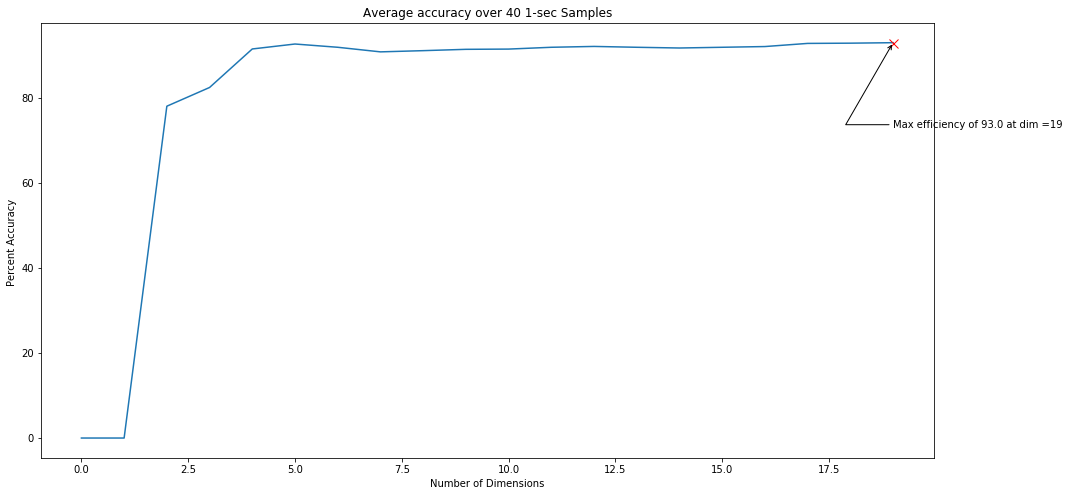

In [24]:
fig = plt.figure(num=None,figsize=(16,8))
ax = fig.add_subplot(111)
x=np.arange(0,acc.shape[0])
y=acc.mean(axis=1)
line, = ax.plot(x, y,label= 'Music 1 sec sample # '+str(i+1))

ymax = max(y)
xpos = np.argmax(y)
xmax = x[xpos]
ax.plot([xmax], [ymax], marker='x', markersize=9, color="red")
arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
ax.annotate('Max efficiency of '+str('%.1f' %ymax)+' at dim ='+str(xmax), xy=(xmax, ymax), xytext=(xmax, ymax-20),
            arrowprops=arrowprops,
            )
plt.xlabel('Number of Dimensions')
plt.ylabel('Percent Accuracy ')
plt.title('Average accuracy over 40 1-sec Samples')

#### Speech Samples
- Let's see how accurately we can classify 5 speech samples

In [59]:
redu_dim = 20
acc_s = np.zeros((redu_dim,num_test_samples))

for u in range(2, redu_dim):
    dim = u
    
    W_all    = PCA(dim, fy)
    Z_music  = np.dot(W_all, music_train)
    Z_speech = np.dot(W_all, speech_train)
    
    m_music  = np.mean(Z_music, axis=1)
    m_speech = np.mean(Z_speech, axis=1)
    
    c_music  = np.cov(Z_music)
    c_speech = np.cov(Z_speech) 
    
    g_s = np.empty((2,88, num_test_samples), dtype='float')
    
    for i in range(0, num_test_samples):
        Z_sample = np.dot(W_all,speech_validate_set[:,:,i])
        a = Z_sample.T - m_music
        b = Z_sample.T - m_speech
        
        g_s[0,:,i] = -0.5*np.sum(np.dot(a, np.linalg.inv(c_music))*a, axis=1) - 2*0.5*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(c_music))
        g_s[1,:,i] = -0.5*np.sum(np.dot(b, np.linalg.inv(c_speech))*b, axis=1) -2*0.5*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(c_speech))

    p_s = np.empty((num_test_samples,88))
    for j in range(0, num_test_samples):
        for i in range(0,88):
            p_s[j,i] = np.argmax(g_s[:,i,j])
    
    for j in range(0, num_test_samples):
        acc_s[u,j] = (float(np.sum(p_s[j,:]))/88.0)*100

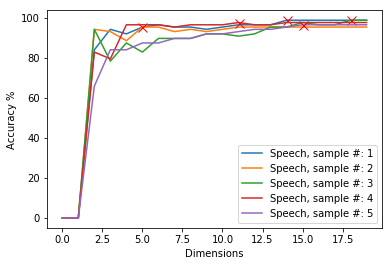

In [60]:
fig = plt.figure(num=None)
ax = fig.add_subplot(111)

for i in range(0,5):
    x = np.arange(0,acc_s.shape[0])
    y = acc_s[:,i]
    line, = ax.plot(x,y,label= 'Speech, sample #: '+ str(i+1))
    ymax = max(y)
    xpos = np.argmax(y)
    xmax = x[xpos]
    ax.plot([xmax], [ymax], marker='x', markersize=9, color="red")
    ax.label = 'Speech Sample n'
    
plt.xlabel('Dimensions')
plt.ylabel('Accuracy %')
plt.legend()

plt.show()

We get above 95% accuracy in classifying music samples.

#### All Speech Samples
- Now we can test all of music data set with various dimensionality reductions to see performance

Text(0.5,1,'Average accuracy over 40 1-sec Samples')

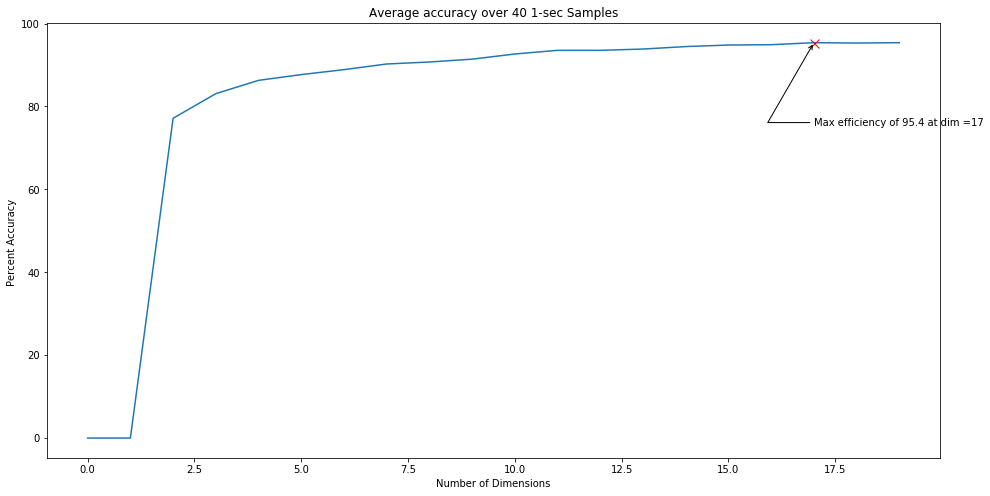

In [62]:
fig = plt.figure(num=None,figsize=(16,8))
ax = fig.add_subplot(111)
x=np.arange(0,acc_s.shape[0])
y=acc_s.mean(axis=1)
line, = ax.plot(x, y,label= 'Speech 1 sec sample # '+str(i+1))

ymax = max(y)
xpos = np.argmax(y)
xmax = x[xpos]
ax.plot([xmax], [ymax], marker='x', markersize=9, color="red")
arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
ax.annotate('Max efficiency of '+str('%.1f' %ymax)+' at dim ='+str(xmax), xy=(xmax, ymax), xytext=(xmax, ymax-20),
            arrowprops=arrowprops,
            )
plt.xlabel('Number of Dimensions')
plt.ylabel('Percent Accuracy ')
plt.title('Average accuracy over 40 1-sec Samples')

### Part 7 - Conclusion

We can see the average accuracy 40 1-sec samples is highest at 19 dimensions for music and 17 for speech. Looking at the plot, we can get above 90% accuracy after 5 dimensions suggesting that speech and music data are inherently separable. Future extensions can include using another model instead of Gaussian and redefining the accuracy function.